In [29]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import torch
from adabmDCA.fasta import get_tokens
from adabmDCA.stats import get_correlation_two_points, get_freq_single_point, get_freq_two_points
from annadca.rbm import get_rbm
from annadca.dataset import annaDataset
from annadca.utils.analysis import get_eigenvalues_history
from annadca.plot import plot_PCA

In [ ]:
fname_data = "/home/lorenzo/Documents/paths-specificity/SAM/SAM_MSA.fasta"
fname_mt = "/home/lorenzo/Documents/paths-specificity/SAM/SAM_tms.txt"

from adabmDCA.fasta import import_from_fasta
import pandas as pd

tokens = get_tokens("rna")
h, s = import_from_fasta(fname_data)
print(len(s))
l = np.loadtxt(fname_mt)
df = pd.DataFrame({
    "header": h,
    "sequence": s,
    "label": l
})
df.to_csv("example_data/SAM.csv", index=False)

9693


ValueError: All arrays must be of the same length

In [35]:
len(s), len(l)

(9693, 10082)

In [4]:
#fname_data = "../example_data/MNIST_train.csv"
#checkpoint_dir = "../models/relu_checkpoints"
#fname_model = os.path.join(checkpoint_dir, "model_update_10000.pt")

fname_data = "../example_data/Natural_CM.csv"
checkpoint_dir = "../models/CM_bernoulli2_checkpoints"
fname_model = os.path.join(checkpoint_dir, "model_update_20000.pt")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [6]:
# Import dataset
tokens = get_tokens("protein")
dataset = annaDataset(
    path_data=fname_data,
    column_names="header",
    column_sequences="sequence",
    column_labels="label",
    alphabet=tokens,
    path_weights=None,
    no_reweighting=False,
    is_binary=False,
    device=device,
    dtype=dtype,
)

data = dataset.data_one_hot
weights = dataset.weights.view(-1)
labels_data = dataset.to_label(dataset.labels_one_hot)

# Load the model and the chains
checkpoint = torch.load(fname_model, map_location=device)
rbm = get_rbm(
    visible_type="potts",
    hidden_type="bernoulli",
    visible_shape=checkpoint["model_state_dict"]["weight_matrix"].shape[0:2],
    hidden_shape=checkpoint["model_state_dict"]["weight_matrix"].shape[2],
    num_classes=dataset.get_num_classes(),
)

rbm.load_state_dict(checkpoint["model_state_dict"])
rbm.to(device=device, dtype=dtype)

chains = checkpoint["chains"]
labels_chains = dataset.to_label(chains["label"])

In [7]:
fi = get_freq_single_point(data, weights=weights, pseudo_count=1e-8)
fij = get_freq_two_points(data, weights=weights, pseudo_count=1e-8)
pi = get_freq_single_point(chains["visible"])
pij = get_freq_two_points(chains["visible"])
rho, slope = get_correlation_two_points(fij, pij, fi, pi)
print(f"Correlation: {rho}, Slope: {slope}")

Correlation: 0.9098209738731384, Slope: 0.9631189107894897


In [8]:
# Project data and chains on the same PCA space
pca = PCA(n_components=2)
data_flat = data.view(len(data), -1)
data_proj = pca.fit_transform(data_flat.cpu().numpy())
chains_proj = pca.transform(chains["visible"].view(len(chains["visible"]), -1).cpu().numpy())

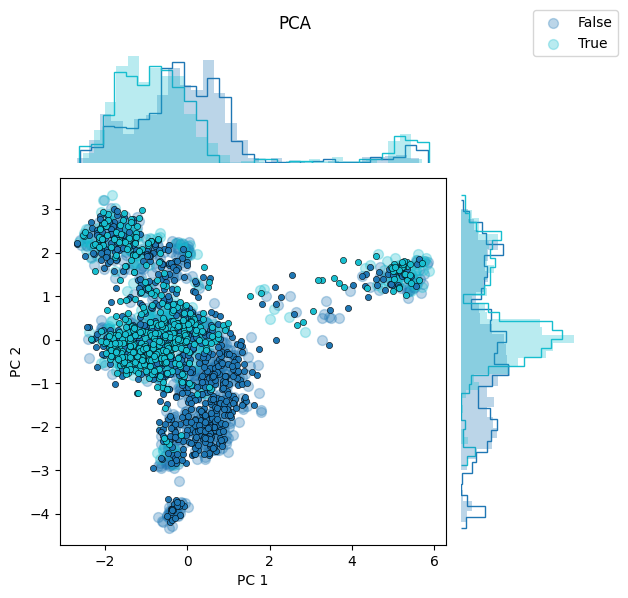

In [9]:
# Define the colors
unique_labels = np.unique(labels_data)
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=chains_proj,
    labels2=labels_chains,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)
fig.legend(bbox_to_anchor=(1.05, 1.0))
fig.tight_layout()

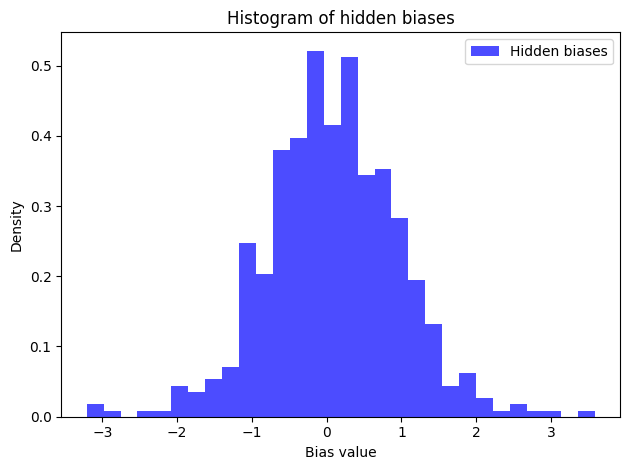

In [10]:
plt.hist(
    rbm.hidden_layer.bias.detach().cpu().numpy(),
    bins=30,
    density=True,
    alpha=0.7,
    color="blue",
    label="Hidden biases",
);
plt.legend()
plt.xlabel("Bias value")
plt.ylabel("Density")
plt.title("Histogram of hidden biases")
plt.tight_layout()

In [8]:
plt.hist(
    rbm.hidden_layer.scale.detach().cpu().numpy(),
    bins=30,
    alpha=0.7,
    color="blue",
    label="Hidden scales",
)
plt.legend()
plt.xlabel("Scale value")
plt.ylabel("Density")
plt.title("Histogram of hidden scales")
plt.tight_layout()

AttributeError: 'BernoulliLayer' object has no attribute 'scale'

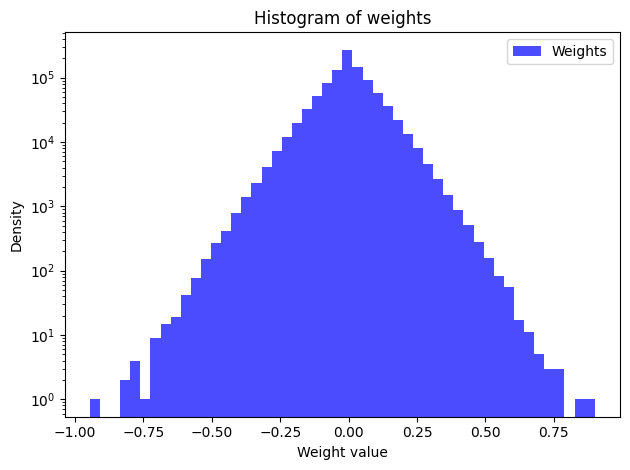

In [11]:
plt.hist(
    rbm.weight_matrix.detach().cpu().flatten().numpy(),
    bins=50,
    alpha=0.7,
    color="blue",
    label="Weights",
)
plt.legend()
plt.xlabel("Weight value")
plt.ylabel("Density")
plt.title("Histogram of weights")
plt.yscale("log")
plt.tight_layout()

### Sample unconditioned

In [12]:
samples = rbm.sample(gibbs_steps=10000, num_samples=10000)
samples_proj = pca.transform(samples["visible"].view(len(samples["visible"]), -1).cpu().numpy())
samples_labels = dataset.to_label(samples["label"])

W1006 14:44:10.737000 1685192 site-packages/torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


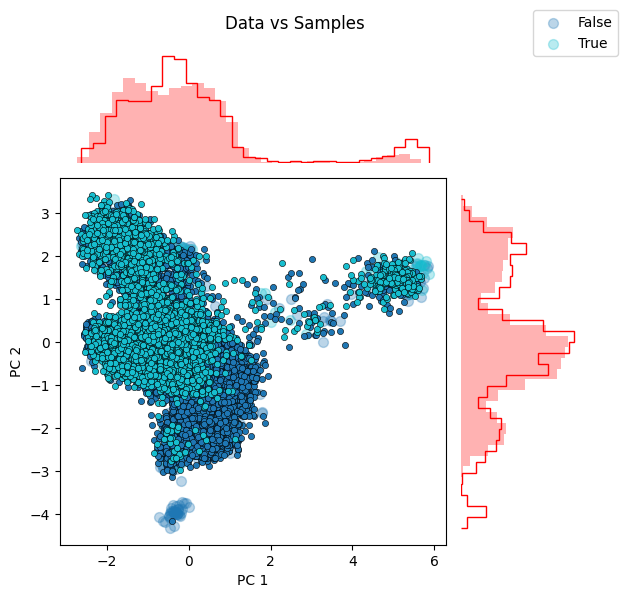

In [13]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=samples_proj,
    labels2=samples_labels,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="Data vs Samples",
    split_labels=False,
)

fig.legend(bbox_to_anchor=(1.05, 1.0))
fig.tight_layout()

In [14]:
pi = get_freq_single_point(samples["visible"])
pij = get_freq_two_points(samples["visible"])
rho, slope = get_correlation_two_points(fij, pij, fi, pi)
print(f"Correlation: {rho}, Slope: {slope}")

Correlation: 0.882956862449646, Slope: 0.9225055575370789


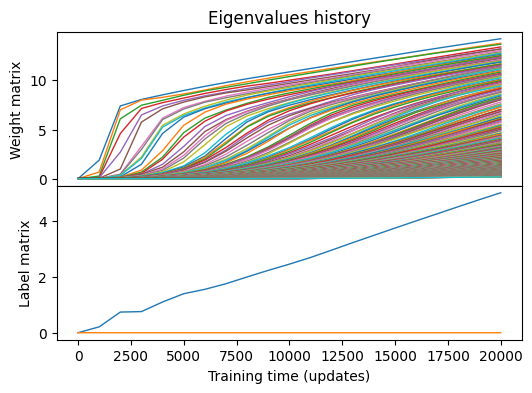

In [15]:
updates, eigenvalues = get_eigenvalues_history(checkpoint_dir, target_matrix="weight_matrix", device=device, dtype=dtype)
updates, eigenvalues_labels = get_eigenvalues_history(checkpoint_dir, target_matrix="label_matrix", device=device, dtype=dtype)

# Plot the eigenvalues history. first row is the weight matrix, second row is the label matrix.
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})
ax[0].plot(updates, eigenvalues, lw=1)
ax[1].plot(updates, eigenvalues_labels, lw=1)
ax[1].set_xlabel("Training time (updates)")
ax[0].set_ylabel("Weight matrix")
ax[1].set_ylabel("Label matrix")
ax[0].set_title("Eigenvalues history");

### Conditioned sampling

In [19]:
cond_chains = rbm.sample_conditioned(
    gibbs_steps=100000,
    targets=dataset.labels_one_hot,
)

In [21]:
cond_chains_proj = pca.transform(cond_chains["visible"].view(len(cond_chains["visible"]), -1).cpu().numpy())
cond_chains_labels = labels_data

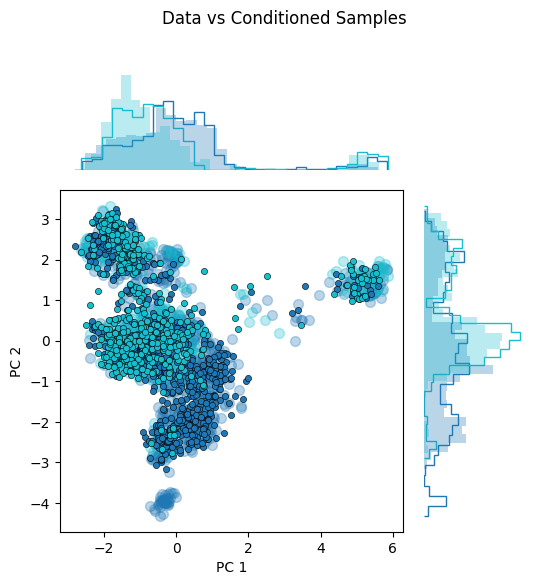

In [22]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=cond_chains_proj,
    labels2=cond_chains_labels,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="Data vs Conditioned Samples",
    split_labels=True,
)

In [23]:
pi = get_freq_single_point(cond_chains["visible"])
pij = get_freq_two_points(cond_chains["visible"])
rho, slope = get_correlation_two_points(fij, pij, fi, pi)
print(f"Correlation: {rho}, Slope: {slope}")

Correlation: 0.8321749567985535, Slope: 0.9672834873199463


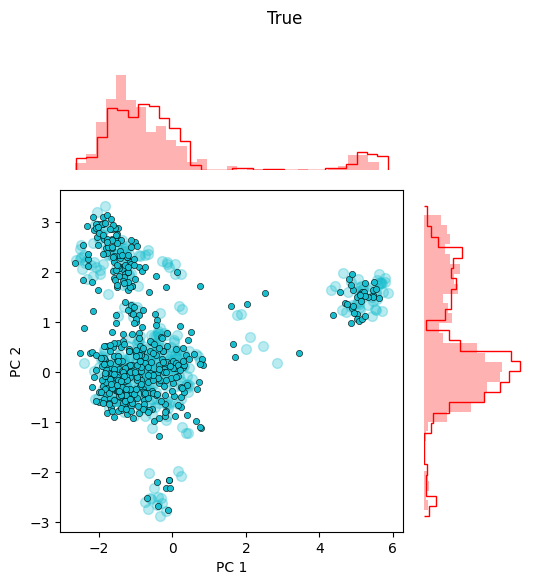

In [24]:
# Plot pca of conditioned chains and data but only one label
label_idx = 1
label = dataset.idx_to_label[label_idx]
mask_data = labels_data == label
mask_gen = cond_chains_labels == label
data_proj_label = data_proj[mask_data]
chains_proj_label = cond_chains_proj[mask_gen]

fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj_label,
    labels1=labels_data[mask_data],
    data2=chains_proj_label,
    labels2=cond_chains_labels[mask_gen],
    label_to_color={label: cmap(label_idx)},
    dim1=0,
    dim2=1,
    title=label,
    split_labels=False,
)

In [25]:
predictions = rbm.predict_labels(visible=dataset.data_one_hot)
accuracy = (predictions.argmax(-1) == dataset.labels_one_hot.argmax(-1)).float().mean().item()
print(f"Train accuracy: {accuracy}")

Train accuracy: 0.922123908996582


### Check energies

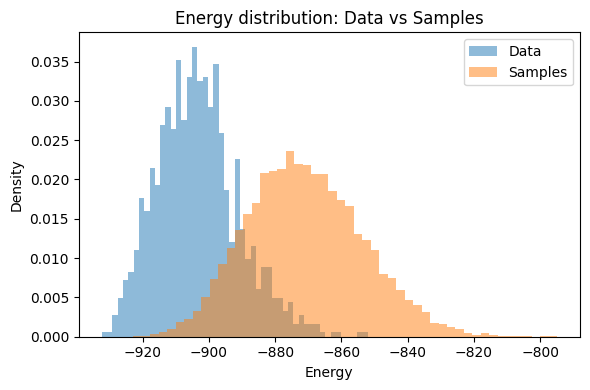

In [26]:
energy_data = rbm.compute_energy_visibles(data)
energy_samples = rbm.compute_energy_visibles(samples["visible"])

plt.figure(figsize=(6,4))
plt.hist(energy_data.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Data")
plt.hist(energy_samples.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Samples")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.title("Energy distribution: Data vs Samples")
plt.tight_layout()

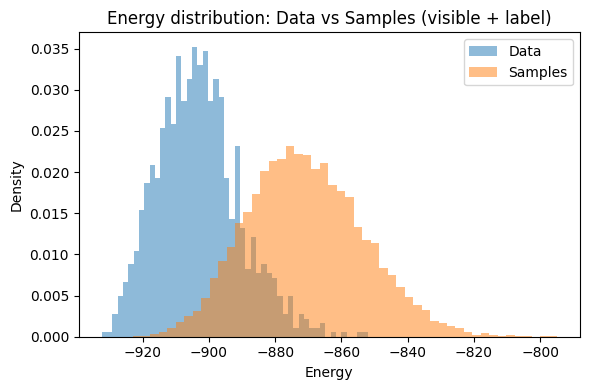

In [27]:
energy_visible_label_data = rbm.compute_energy_visibles_labels(data, dataset.labels_one_hot)
energy_visible_label_samples = rbm.compute_energy_visibles_labels(samples["visible"], samples["label"])

plt.figure(figsize=(6,4))
plt.hist(energy_visible_label_data.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Data")
plt.hist(energy_visible_label_samples.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Samples")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.title("Energy distribution: Data vs Samples (visible + label)")
plt.tight_layout()

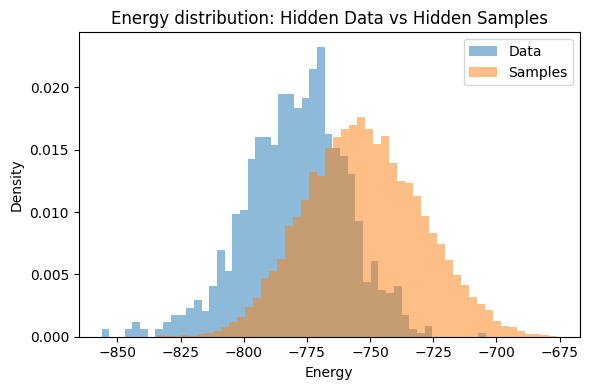

In [28]:
hidden_data = rbm.sample_hiddens(data, label=dataset.labels_one_hot)
energy_hidden_data = rbm.compute_energy_hiddens(hidden_data)
energy_hidden_samples = rbm.compute_energy_hiddens(samples["hidden"])

plt.figure(figsize=(6,4))
plt.hist(energy_hidden_data.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Data")
plt.hist(energy_hidden_samples.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Samples")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.title("Energy distribution: Hidden Data vs Hidden Samples")
plt.tight_layout()

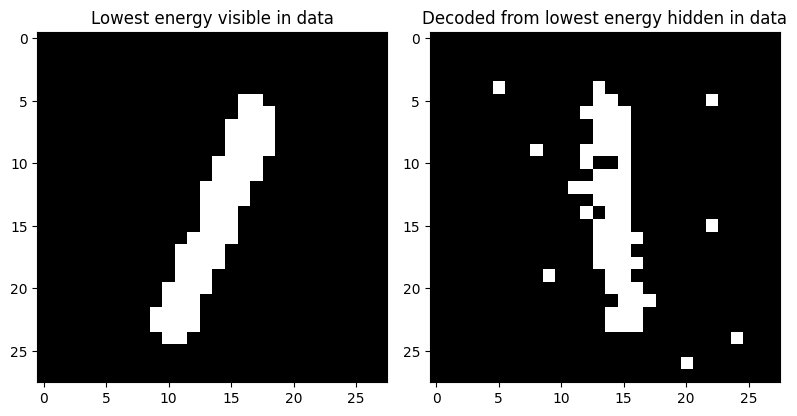

In [221]:
lowest_energy_hidden = hidden_data[energy_hidden_data.argmin()]
lowest_energy_hidden_decoded = rbm.sample_visibles(lowest_energy_hidden)
lowest_energy_visible = data[energy_data.argmin()]

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(lowest_energy_visible.view(28,28).cpu(), cmap="gray")
ax[0].set_title("Lowest energy visible in data")
ax[1].imshow(lowest_energy_hidden_decoded.view(28,28).cpu(), cmap="gray")
ax[1].set_title("Decoded from lowest energy hidden in data")
fig.tight_layout()

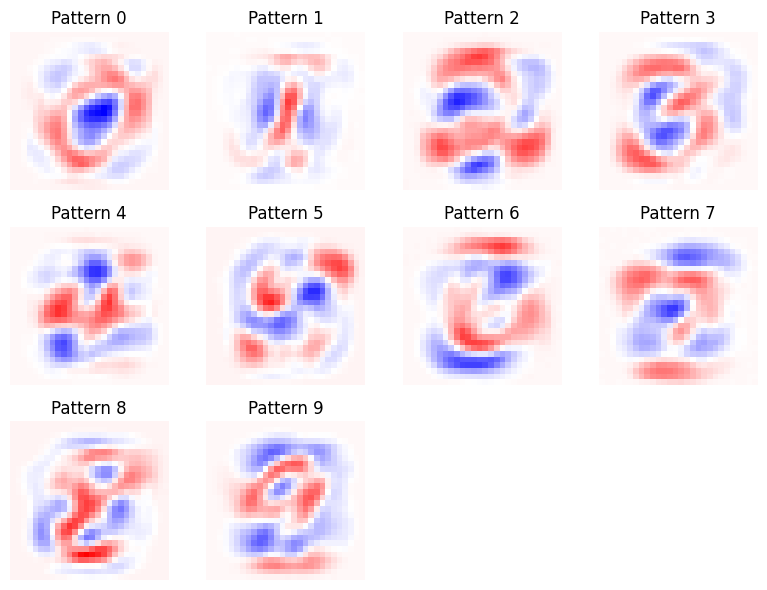

In [222]:
patterns = rbm.get_patterns()

plt.figure(figsize=(8,6))
num_patterns = patterns.shape[0]
for i in range(num_patterns):
    plt.subplot(int(np.ceil(num_patterns/4)), 4, i+1)
    plt.imshow(patterns[i].cpu().numpy().reshape(28,28), cmap='bwr', vmin=patterns.min(), vmax=patterns.max())
    plt.axis('off')
    plt.title(f'Pattern {i}')
plt.tight_layout()